In [ ]:
!pip install cirq --pre

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import recirq.mbl_dtc as dtc_utils

In [3]:
# Variables used across all figures

# define the qubits we'll be using
qubit_locations = [(3, 9), (3, 8), (3, 7), (4, 7), (4, 8), (5, 8), (5, 7), (5, 6), (6, 6), (6, 5), (7, 5), (8, 5),
              (8, 4), (8, 3), (7, 3), (6, 3)]

qubits = [cirq.GridQubit(*idx) for idx in qubit_locations]
num_qubits = len(qubits)

# prepare our DTC circuit list, with 0 through 100 cycles
num_cycles = 100
circuit_list = dtc_utils.symbolic_dtc_circuit_list(qubits=qubits, cycles=num_cycles)

<timed exec>:96: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 17min 6s, sys: 1.36 s, total: 17min 8s
Wall time: 17min 8s


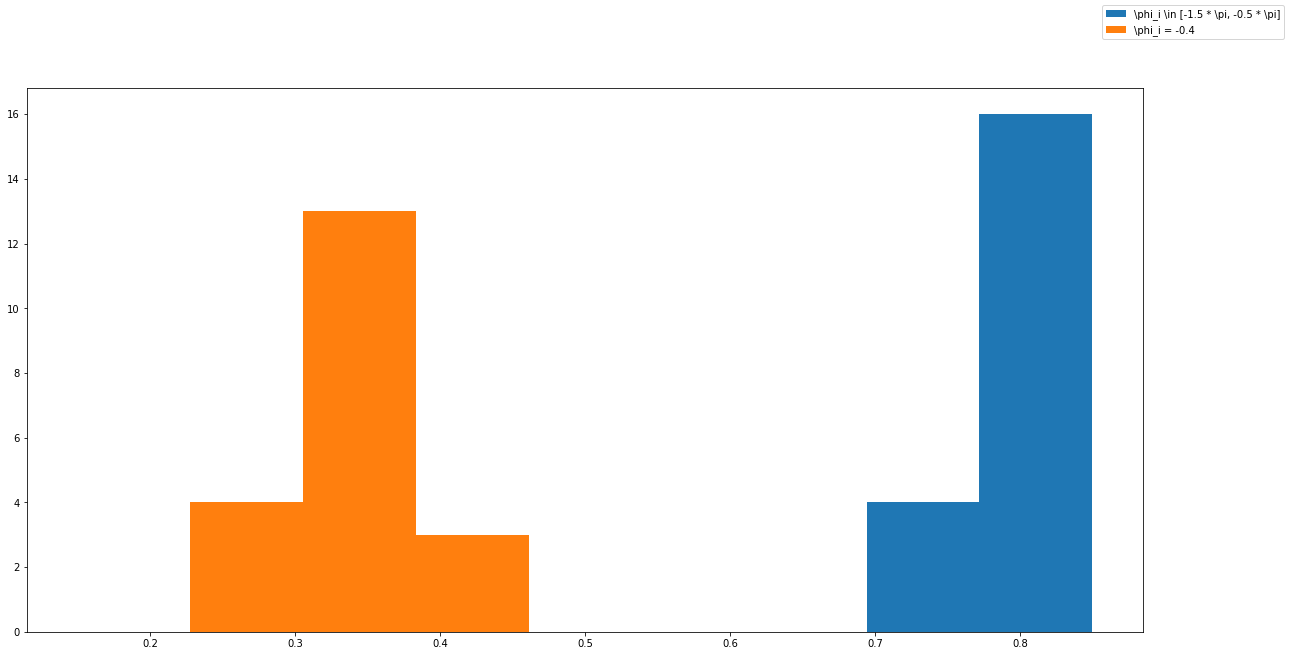

In [4]:
%%time
# Figure 3b

# constants for thermalization (g), and instances for disorder and random initial states
disorder_instances = 24
initial_state_instances = 20 # is 500 in the paper
g = 0.94

# use thermalization (g) for all instances
gs = np.full(disorder_instances, g)

# parameters for two-qubit FSim gates
# zeros for theta, zeta, chi
thetas = np.zeros((disorder_instances, num_qubits))
zetas = np.zeros((disorder_instances, num_qubits))
chis = np.zeros((disorder_instances, num_qubits))

# prepare random initial states
initial_states = np.random.choice(2, (initial_state_instances, num_qubits))

# disorder instances h and phi
local_fields = np.random.uniform(-1.0, 1.0, (disorder_instances, num_qubits))
disordered_phis = np.random.uniform(-1.5*np.pi, -0.5*np.pi, (disorder_instances, num_qubits))

# expand fixed phis for all instances and qubits
fixed_phi = -0.4
fixed_phis = np.full((disorder_instances, num_qubits), fixed_phi)

# only look at circuits with up to 31 cycles
circuit_list_3b = circuit_list[:32]

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# create a param resolver sweep over initial states
initial_state_instance_sweep = dtc_utils.dtc_param_resolver_sweep(None, initial_states, None, None, None, None, None)

# set phi labels
phi_labels = ['\phi_i \in [-1.5 * \pi, -0.5 * \pi]', '\phi_i = -0.4']

for random_phi, phi_label in zip([True, False], phi_labels): 
    # use either random, disordered phis or fixed ones
    if random_phi: 
        phis = disordered_phis
    else: 
        phis = fixed_phis
    # gamma dependent on phis
    gammas = -1/2*phis

    # create a param resolver sweep over the disorder instances
    disorder_instance_sweep = dtc_utils.dtc_param_resolver_sweep(gs, None, local_fields, thetas, zetas, chis, gammas, phis)

    # create the param resolver sweep we're going to use, as a product of the disorder and initial state sweeps
    param_resolvers = cirq.Product(initial_state_instance_sweep, disorder_instance_sweep)

    # allocate ndarray to hold polarizations
    average_polarizations = np.zeros((initial_state_instances, disorder_instances, 2))

    # prepare simulation generator
    probabilities_generator = dtc_utils.simulate_dtc_circuit_list_sweep(circuit_list_3b, param_resolvers, qubits)
    
    # simulate and get probabilities
    for index, instance_probabilities in enumerate(probabilities_generator): 
        # our product sweep iterates over initial_state instances, then disorder instances
        # separate out the indices of initial_state and disorder from the overall index
        initial_state_index = index // disorder_instances 
        disorder_index = index % disorder_instances

        # only consider cycles 30 and 31
        instance_probabilities = instance_probabilities[-2:, :]

        # select the correct initial state to compare polarizations against
        initial_state = initial_states[initial_state_index]

        # turn probabilities into polarizations, relative to initial state
        instance_polarizations = dtc_utils.get_polarizations(instance_probabilities, num_qubits, cycles_axis=0, probabilities_axis=1, initial_states=initial_state)

        # average over qubit site
        average_instance_polarizations = np.mean(instance_polarizations, axis=1)

        # store average instance polarizations in overall average polarizations ndarray
        average_polarizations[initial_state_index, disorder_index, :] = average_instance_polarizations
    
    # average over disorder
    average_polarizations = np.mean(average_polarizations, axis=1)

    # take absolute value
    average_polarizations = np.abs(average_polarizations)

    # average over cycles
    average_polarizations = np.mean(average_polarizations, axis=1)

    # plot in a histogram
    axis.hist(average_polarizations, label=phi_label, bins=np.linspace(0.15, 0.85, initial_state_instances//2))

# add legend and show
fig.legend()
fig.show()